In [22]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tqdm import tqdm
from time import time
from scipy import stats
from sklearn import neighbors
from sklearn.model_selection import StratifiedKFold

from pyspark.ml import Pipeline
from pyspark.ml.linalg import Vectors
from pyspark.ml.tuning import ParamGridBuilder
from pyspark.ml.tuning import TrainValidationSplit
from pyspark.sql import Row
from pyspark.sql import SparkSession
from pyspark.sql.types import IntegerType
from pyspark.sql.types import DoubleType
from pyspark.sql.functions import rand
from pyspark.sql.functions import col
from pyspark.ml.feature import StandardScaler
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import RobustScaler
from pyspark.ml.feature import StringIndexer
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.classification import LinearSVC
from pyspark.ml.classification import MultilayerPerceptronClassifier
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

In [23]:
class FraudDetection():
    def __init__(self):
        self.spark = None
        self.data = None
        self.rep_data = None # repeated data
        
    def create_spark_context(self, ram, rpt=False, ret=False):
        self.spark = SparkSession.\
            builder.\
            appName("Fraud Detector").\
            master("spark://spark-master:7077").\
            config("spark.executor.memory", "{}g".format(ram)).\
            getOrCreate()
        if rpt: print(self.spark.sparkContext.getConf().getAll())
        if ret: return self.spark
    
    def read_file(self, path, rpt=False, ret=False):
        self.data = self.spark.read.csv(path, header=True, inferSchema=True)
        if rpt: print('number of partitions: {}'.format(self.data.rdd.getNumPartitions()))
        if ret: return self.data
    
    def data_duplicator(self, number, rpt=False, ret=False):
        self.rep_data = self.data
        for i in range(number-1):
            self.rep_data = self.data.union(self.rep_data)
        if rpt: print("Created df with: {}, {}".format(self.rep_data .count(), len(self.rep_data .columns)))
        if ret: return self.rep_data

        
class Preprocess():
    def __init__(self, data):
        self.spark = None
        self.sub_sample = None
        self.data = data
        
    def scale_column(self, feature):
        self.data = self.data.withColumn(feature, self.data[feature].cast(IntegerType()))
        assembler = VectorAssembler().setInputCols([feature]).setOutputCol('f'+feature)
        self.data = assembler.transform(self.data)
        self.data = self.data.drop(feature)
        scaler = RobustScaler(inputCol="f"+feature, outputCol=feature,
                          withScaling=True, withCentering=False,
                          lower=0.25, upper=0.75)
        scalerModel = scaler.fit(self.data)
        self.data = scalerModel.transform(self.data)
        self.data = self.data.drop('f'+feature)
        unlist = udf(lambda x: float(list(x)[0]), DoubleType())
        self.data = self.data.withColumn(feature, unlist(feature))
        return self.data
    
    def robust_scale(self, scale_columns):
        for column in scale_columns:
            self.data = self.scale_column(column)
        return self.data
    
    def calculate_iqr_bound(self, feature, q1, q3, k, rpt=False):
        bound = self.sub_sample.filter(self.data.Class==1).approxQuantile(feature, [q1, q3], 0)
        if rpt: print(f'Feature: {feature}, Lower bound: {bound[0]}, Upper bound: {bound[1]}')
        iqr = bound[1] - bound[0]
        if rpt: print(f'Feature: {feature}, IQR: {iqr}')
        bound[0] = bound[0] - (iqr * k)
        bound[1] = bound[1] + (iqr * k)
        if rpt: print(f'Feature: {feature}, Cut-off Lower bound: {bound[0]}, Cut-off Upper bound: {bound[1]}')
        return bound
    
    def outlier_removal(self, features, q1=0.25, q3=0.75, k=1.5, rpt=False):
        frauds = self.data.filter(self.data.Class==1)
        self.sub_sample = frauds.union(self.data.filter(self.data.Class==0).limit(492))
        for feature in features:
            before_removal_count = self.sub_sample.count()
            bound = self.calculate_iqr_bound(feature, q1, q3, k, rpt=rpt)
            self.sub_sample = self.sub_sample.filter((col(feature) >= bound[0]) & (col(feature) <= bound[1]))
            after_removal_count = self.sub_sample.count()
            if rpt: print(f'before removal count: {before_removal_count}, after removal count: {after_removal_count}')
    
    def assemble_features(self):
        assembler = VectorAssembler(inputCols=['V{}'.format(i) for i in range(1,29)], outputCol='features')
        self.data = assembler.transform(self.data)
        return self.data

    
class Evaluator():
    def __init__(self):
        pass
    
    def accuracy(self, data):
        accuracy_evaluator = MulticlassClassificationEvaluator(labelCol="prediction", predictionCol="class", metricName="accuracy")
        print('accuracy: {}'.format(accuracy_evaluator.evaluate(data)))
        
    def recall(self, data):
        recall_evaluator = MulticlassClassificationEvaluator(labelCol="prediction", predictionCol="class", metricName="recallByLabel")
        print('recall: {}'.format(recall_evaluator.evaluate(data)))
    
    def recall(self, data):
        recall_evaluator = MulticlassClassificationEvaluator(labelCol="prediction", predictionCol="class", metricName="recallByLabel")
        print('recall: {}'.format(recall_evaluator.evaluate(data))) 

In [24]:
ram=16
duplicate=1
splitation=[0.7, 0.1, 0.2]
detector = FraudDetection()
detector.create_spark_context(ram=ram)
detector.read_file("/opt/workspace/bank_sim.csv", True)
detector.data_duplicator(duplicate, True)

number of partitions: 8
Created df with: 594643, 10


In [25]:
class Preprocess():
    def __init__(self, df):
        self.df = df
        
    def drop_columns(self, columns = ['zipcodeOri', 'zipMerchant']):
        for col in columns:
            self.df = self.df.drop('zipcodeOri')
            self.df = self.df.drop('zipMerchant')
    
    def index_column(self, df, column):
        indexer = StringIndexer(inputCol=column, outputCol=column+"Index")
        df = indexer.fit(df).transform(df)
        df = df.withColumn(column, df[column+"Index"].cast(IntegerType()))
        df = df.drop(column+"Index")
        return df
    
    def columns_indexing(self, columns = ['merchant', 'category', 'customer', 'age', 'gender']):
        for column in columns:
            self.df = self.index_column(self.df, column)

In [26]:
preprocess = Preprocess(detector.rep_data)
preprocess.drop_columns()
preprocess.columns_indexing()
detector.rep_data = preprocess.df

In [27]:
class FeatureExtraction():
    def __init__(self, df):
        self.df = df
        self.merchant_fraud_probablites = None
    
    def merchant_fraud_probablity(self, merchant):
        merchant_df = self.df.filter(self.df.merchant==merchant)
        return merchant_df.filter(merchant_df.fraud==1).count()/merchant_df.count()
    
    def merchants_fruad_probablity(self):
        merchants = self.df.toPandas()['merchant'].unique()
        self.merchant_fraud_probablites = {}
        for merchant in merchants:
            self.merchant_fraud_probablites[merchant] = self.merchant_fraud_probablity(int(merchant))
        return self.merchant_fraud_probablites
    
    @staticmethod
    def merchant_probablity(merchant, x):
        return probs[merchant]
    
    def extract_merchant_fraud_probablity(self, probs):
        self.df = self.df.rdd.map(lambda x: x + (func1(x["merchant"], probs),)).toDF(self.df.columns + ["merchantProbablity"])
        
    def customer_trans(self):
        _customers_trans = {}
        for row in self.df.collect():
            customer_trans = _customers_trans.get(row.customer, None)
            if customer_trans is None:
                customer_trans = {}
            if row.step in customer_trans:
                customer_trans[row.step+1] = row.amount
            else:
                customer_trans[row.step] = row.amount
            _customers_trans[row.customer] = customer_trans
        customer_trans_broadcast = detector.spark.sparkContext.broadcast(_customers_trans)
        return customer_trans_broadcast
        
    def last_variance(customer, step, current_amount, customer_trans_broadcast):
        customer_trans = customer_trans_broadcast.value.get(customer)
        trans = [v for k,v in customer_trans.items() if k < step]
    #     check this, must be 0 or -1
        prev_amount = trans[-1] if len(trans) > 0 else 0
        if int(prev_amount) == 0: return 0.0
        variance = (int(current_amount) - int(prev_amount))/int(prev_amount)
        return variance
        
    def extract_last_variance(self, customer_trans_broadcast):
        self.df = self.df.rdd.map(lambda x: x + (last_variance(int(x["customer"]), int(x['step']), int(x["amount"]), customer_trans_broadcast),)).toDF(self.df.columns + ["lastVariance"])
        return self.df

In [28]:
def func1(merchant, probs):
    return probs[merchant]

def last_variance(customer, step, current_amount, customer_trans_broadcast):
    customer_trans = customer_trans_broadcast.value.get(customer)
    trans = [v for k,v in customer_trans.items() if k < step]
    prev_amount = trans[-1] if len(trans) > 0 else 0
    if int(prev_amount) == 0: return 0.0
    variance = (int(current_amount) - int(prev_amount))/int(prev_amount)
    return variance

featureExtraction = FeatureExtraction(detector.rep_data)
featureExtraction.extract_merchant_fraud_probablity(featureExtraction.merchants_fruad_probablity())
customer_trans_broadcast = featureExtraction.customer_trans()
df = featureExtraction.extract_last_variance(customer_trans_broadcast)

In [29]:
import pyspark.sql.functions as func
df = df.withColumn('lastVariance', func.round(df["lastVariance"], 4))
df = df.withColumn('merchantProbablity', func.round(df["merchantProbablity"], 4))

In [30]:
# df = df.drop('features')
# inputCols = [
#  'customer',
#  'age',
#  'gender',
#  'merchant',
#  'category',
#  'amount',
    
#  'merchantProbablity',
#  'lastVariance'
# ]
# assembler = VectorAssembler(inputCols=inputCols, outputCol='features')
# df = assembler.transform(df)

# train, validation, test = df.randomSplit([0.7, 0.1, 0.2], seed=123)

In [31]:
import random
random.seed(123)

def vectorizerFunction(dataInput, TargetFieldName):
    if(dataInput.select(TargetFieldName).distinct().count() != 2):
        raise ValueError("Target field must have only 2 distinct classes")
    columnNames = list(dataInput.columns)
    columnNames.remove(TargetFieldName)
    dataInput = dataInput.select((','.join(columnNames)+','+TargetFieldName).split(',')) 
    assembler=VectorAssembler(inputCols = columnNames, outputCol = 'features')
    pos_vectorized = assembler.transform(dataInput)
    vectorized = pos_vectorized.select('features',TargetFieldName).withColumn('label',pos_vectorized[TargetFieldName]).drop(TargetFieldName)
    return vectorized

def SmoteSampling(vectorized, k = 5, minorityClass = 1, majorityClass = 0, percentageOver = 200, percentageUnder = 100):
    if(percentageUnder > 100|percentageUnder < 10):
        raise ValueError("Percentage Under must be in range 10 - 100");
    if(percentageOver < 100):
        raise ValueError("Percentage Over must be in at least 100");
    dataInput_min = vectorized[vectorized['label'] == minorityClass]
    dataInput_maj = vectorized[vectorized['label'] == majorityClass]
    feature = dataInput_min.select('features').rdd.map(lambda x: x[0]).collect()
    feature = np.asarray(feature)
    nbrs = neighbors.NearestNeighbors(n_neighbors=k, algorithm='auto').fit(feature)
    neighbours =  nbrs.kneighbors(feature)
    gap = neighbours[0]
    neighbours = neighbours[1]
    pos_ListArray = dataInput_min.drop('label').rdd.map(lambda x : list(x)).collect()
    min_Array = list(pos_ListArray)
    newRows = []
    nt = len(min_Array)
    nexs = percentageOver/100
    for i in range(nt):
        for j in range(int(nexs)):
            neigh = random.randint(1,k)
            difs = min_Array[neigh][0] - min_Array[i][0]
            newRec = (min_Array[i][0]+random.random()*difs)
            newRows.insert(0,(newRec))
    newData_rdd = detector.spark.sparkContext.parallelize(newRows)
    newData_rdd_new = newData_rdd.map(lambda x: Row(features = x, label = 1))
    new_data = newData_rdd_new.toDF()
    new_data_minor = dataInput_min.unionAll(new_data)
    new_data_major = dataInput_maj.sample(False, (float(percentageUnder)/float(100)))
    return new_data_major.unionAll(new_data_minor)


In [32]:
def smote(train, test, sampling=True):
    train = vectorizerFunction(train, 'fraud')
    test = vectorizerFunction(test, 'fraud')

    # percentage under reduce major class. 100 mean all instances of major class
    # percentage over increase minor class. 200 mean each sample of minor class must be doubled
    if sampling:
        train = SmoteSampling(train, k=2, minorityClass=1, majorityClass=0, percentageOver=200, percentageUnder=100)

    train = train.withColumnRenamed('label','fraud')
    test = test.withColumnRenamed('label','fraud')
    return train, test

In [60]:
# must remove
train, validation, test = df.randomSplit([0.7, 0.1, 0.2], seed=123)
# train, test = smote(train, test, False)
print('train count: {}, validation count: {}, test count: {}'.format(train.count(), validation.count(), test.count()))

train count: 417107, validation count: 59473, test count: 118063


In [121]:
def get_customers_df(df):
    x = df.select(['customer', 'gender', 'age']).dropDuplicates(['customer'])
    y = df.groupby('customer').sum('amount')
    y = y.join(x, on=['customer'], how='inner')
    return y

In [120]:
def cluster_customers(df):
    customers = get_customer_df(train)
    assemble=VectorAssembler(inputCols=['age','gender', 'sum(amount)'], outputCol='clustering_features')
    assembled_data=assemble.transform(customers)
    # assembled_data.show(2)
    scale=StandardScaler(inputCol='clustering_features',outputCol='clustering_features_standardized')
    data_scale=scale.fit(assembled_data)
    data_scale_output=data_scale.transform(assembled_data)
    # data_scale_output.show(2)
    silhouette_score=[]
    evaluator = ClusteringEvaluator(predictionCol='prediction', featuresCol='clustering_features_standardized', \
                                    metricName='silhouette', distanceMeasure='squaredEuclidean')
    for i in range(2,10):
        KMeans_algo=KMeans(featuresCol='clustering_features_standardized', k=i)
        KMeans_fit=KMeans_algo.fit(data_scale_output)
        output=KMeans_fit.transform(data_scale_output) 
        score=evaluator.evaluate(output)
        silhouette_score.append(score)
        print("Silhouette Score:",score)

    #Visualizing the silhouette scores in a plot
    fig, ax = plt.subplots(1,1, figsize =(8,6))
    ax.plot(range(2,10),silhouette_score)
    ax.set_xlabel('k')
    ax.set_ylabel('cost')

In [122]:
customers = get_customers_df(train)

Silhouette Score: 0.4391226325095771
Silhouette Score: 0.5666210123718302
Silhouette Score: 0.46188269008006805
Silhouette Score: 0.47638327610956854
Silhouette Score: 0.645959393990168
Silhouette Score: 0.6534655910430988
Silhouette Score: 0.6432507465061351
Silhouette Score: 0.63822393342299


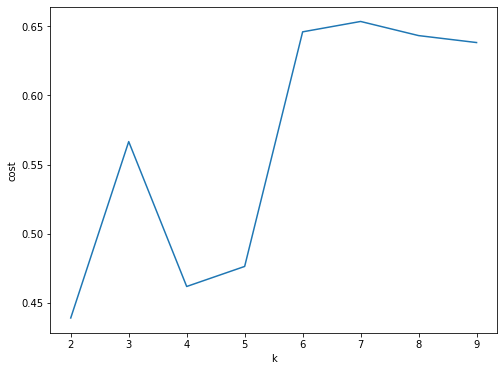

In [124]:
cluster_customers(customers)

In [36]:
train, test = smote(train, test, False)

In [ ]:
df_panda = df.toPandas()
y = np.array(df_panda['fraud'], dtype='float')
X = df_panda.drop(['fraud'], axis=1)

In [ ]:
# Simply using FFNN
def simple_ffnn(train, test):
    print('simple FFNN')
    layers = [9, 5, 2]
    start = time()
    FNN = MultilayerPerceptronClassifier(labelCol="fraud", featuresCol="features", maxIter=100, layers=layers, blockSize=128, seed=123)
    pipeline = Pipeline(stages=[FNN])
    model = pipeline.fit(train)
    predictions = model.transform(test)
    print(time()-start)
    roc_evaluator = BinaryClassificationEvaluator(rawPredictionCol="prediction", labelCol="fraud", metricName="areaUnderROC")
    auc_roc = roc_evaluator.evaluate(predictions)
    print(f'AUC_ROC: {auc_roc}')
#     predictions.show(5)
    return auc_roc

In [ ]:
# convert the data to dense vector
def transData(data):
    return data.rdd.map(lambda r: [r[-1], Vectors.dense(r[:-1])]).toDF(['label','features'])

In [ ]:
def ensemble(train, test):
    print('Ensemble')
    # Random Forest
    rf = RandomForestClassifier(labelCol="fraud", featuresCol="features", numTrees=10, seed=123, maxDepth=8, maxBins=10)
    pipeline = Pipeline(stages=[rf])
    model_rf = pipeline.fit(train)
    predictions_rf = model_rf.transform(train)
    predictions_train_rf = predictions_rf.select("prediction").rdd.flatMap(lambda x: x).collect()
    predictions_test_rf = model_rf.transform(test).select('fraud').rdd.flatMap(lambda x:x).collect()

    # Decision Tree
    dt = DecisionTreeClassifier(labelCol="fraud", featuresCol="features", seed=123)
    pipeline = Pipeline(stages=[dt])
    model_dt = pipeline.fit(train)
    predictions_dt = model_dt.transform(train)
    predictions_train_dt = predictions_dt.select("prediction").rdd.flatMap(lambda x: x).collect()
    predictions_test_dt = model_dt.transform(test).select('fraud').rdd.flatMap(lambda x:x).collect()

    # Logistic Regression
    lr = LogisticRegression(labelCol="fraud", featuresCol="features")
    pipeline = Pipeline(stages=[lr])
    model_lr = pipeline.fit(train)
    predictions_lr = model_lr.transform(train)
    predictions_train_lr = predictions_lr.select("prediction").rdd.flatMap(lambda x: x).collect()
    predictions_test_lr = model_lr.transform(test).select('fraud').rdd.flatMap(lambda x:x).collect()

    # Gradient Boosted
    gb = GBTClassifier(labelCol="fraud", featuresCol="features", seed=123)
    pipeline = Pipeline(stages=[gb])
    model_gb = pipeline.fit(train)
    predictions_gb = model_gb.transform(train)
    predictions_train_gb = predictions_gb.select("prediction").rdd.flatMap(lambda x: x).collect()
    predictions_test_gb = model_gb.transform(test).select('fraud').rdd.flatMap(lambda x:x).collect()

    # SVM
    svm = LinearSVC(labelCol="fraud", maxIter=10, regParam=0.1)
    pipeline = Pipeline(stages=[svm])
    model_svm = pipeline.fit(train)
    predictions_svm = model_svm.transform(train)
    predictions_train_svm = predictions_svm.select("prediction").rdd.flatMap(lambda x: x).collect()
    predictions_test_svm = model_svm.transform(test).select('fraud').rdd.flatMap(lambda x:x).collect()
    
    train_labels = train.select('fraud').rdd.flatMap(lambda x:x).collect()
    test_labels = test.select('fraud').rdd.flatMap(lambda x:x).collect()
    ffnn = []
    for i in range(train.count()):
        ffnn.append([predictions_train_rf[i], predictions_train_dt[i], predictions_train_lr[i], predictions_train_gb[i], predictions_train_svm[i], train_labels[i]])
    models_predict = []
    for i in range(test.count()):
        models_predict.append([predictions_test_rf[i], predictions_test_dt[i], predictions_test_lr[i], predictions_test_gb[i], predictions_test_svm[i], test_labels[i]])
        
    train_df = detector.spark.createDataFrame(ffnn)
    train_df = transData(train_df)
    print(train_df.count())
#     train_df.show()
    
    test_df = detector.spark.createDataFrame(models_predict)
    test_df = transData(test_df)
    print(test_df.count())
#     test_df.show()
    
    layers = [5, 5, 4, 4, 3, 2]
    # layers = [5, 2]
    
    FNN = MultilayerPerceptronClassifier(labelCol="label", featuresCol="features", maxIter=100, layers=layers, blockSize=128, seed=123)
    pipeline = Pipeline(stages=[FNN])
    model = pipeline.fit(train_df)
    predictions = model.transform(test_df)
#     predictions.show(5)
    
    roc_evaluator = BinaryClassificationEvaluator(rawPredictionCol="prediction", labelCol="label", metricName="areaUnderROC")
    auc_roc = roc_evaluator.evaluate(predictions)
    print(f'AUC_ROC: {auc_roc}')
    return auc_roc

In [ ]:
def repeat(default=5):
    auc_roc_arr_method1 = []
    auc_roc_arr_method2 = []
    for i in range(default):
        skf = StratifiedKFold(n_splits=2)
        for train_index, test_index in skf.split(X, y):
            print("TRAIN:", train_index, "TEST:", test_index)
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y[train_index], y[test_index]
            X_train.insert(1, 'fraud', y_train)
            X_test.insert(1, 'fraud', y_test)
            df_train = detector.spark.createDataFrame(X_train)
            df_test = detector.spark.createDataFrame(X_test)
            df_train, df_test = smote(df_train, df_test, False)
            auc_roc_arr_method1.append(simple_ffnn(df_train, df_test))
            auc_roc_arr_method2.append(ensemble(df_train, df_test))
    return auc_roc_arr_method1, auc_roc_arr_method2

In [ ]:
auc_roc_arr_method1, auc_roc_arr_method2 = repeat()

In [ ]:
def get_pvalue(num_round, result_method1, result_method2):
    score_diff = []
    score_diff_2 = []
    for i in range(num_round):
        score_diff.append(auc_roc_arr_method1[i]-auc_roc_arr_method2[i])
        score_diff_2.append((auc_roc_arr_method1[i]-auc_roc_arr_method2[i])**2)
    d = sum(score_diff)
    d2 = sum(score_diff_2)
    numerator = d
    denominator = np.sqrt((num_round*d2 - d**2)/ (num_round - 1))
    t = numerator / denominator
    pvalue = stats.t.sf(np.abs(t), num_round - 1)*2.
    print(pvalue)

    if pvalue <= 0.05:
        print('Difference between mean performance is probably real')
    else:
        print('Algorithms probably have the same performance')
    return pvalue, t

In [ ]:
get_pvalue(10, auc_roc_arr_method1, auc_roc_arr_method2)

In [ ]:
def evaluate_RF(train, test, worker=1):
    start = time()

    rf = RandomForestClassifier(labelCol="fraud", featuresCol="features", numTrees=10, seed=123, maxDepth=8, maxBins=10)
    pipeline = Pipeline(stages=[rf])
    model = pipeline.fit(train)
    predictions = model.transform(test)
    predictions = predictions.withColumn("fraud", predictions["fraud"].cast(DoubleType()))
#     print(f'Elapsed time is: {time()-start}, with {worker} worker')

    roc_evaluator = BinaryClassificationEvaluator(rawPredictionCol="prediction", labelCol="fraud", metricName="areaUnderROC")
    auc_roc = roc_evaluator.evaluate(predictions)
    print(f'AUC_ROC: {auc_roc}')

    accuracy_evaluator = MulticlassClassificationEvaluator(labelCol="fraud", predictionCol="prediction", metricName="accuracy")
    acc = accuracy_evaluator.evaluate(predictions)
    print(f'Accuracy: {acc}')
    
    return auc_roc, acc, time()-start

In [ ]:
def evaluate_DT(train, test, worker=1):
    start = time()

    rf = DecisionTreeClassifier(labelCol="fraud", featuresCol="features", seed=123)
    pipeline = Pipeline(stages=[rf])
    model = pipeline.fit(train)
    predictions = model.transform(test)
    predictions = predictions.withColumn("fraud", predictions["fraud"].cast(DoubleType()))
#     print(f'Elapsed time is: {time()-start}, with {worker} worker')

    roc_evaluator = BinaryClassificationEvaluator(rawPredictionCol="prediction", labelCol="fraud", metricName="areaUnderROC")
    auc_roc = roc_evaluator.evaluate(predictions)
    print(f'AUC_ROC: {auc_roc}')

    accuracy_evaluator = MulticlassClassificationEvaluator(labelCol="fraud", predictionCol="prediction", metricName="accuracy")
    acc = accuracy_evaluator.evaluate(predictions)
    print(f'Accuracy: {acc}')
    
    return auc_roc, acc, time()-start

In [ ]:
def evaluate_LR(train, test, worker=1):
    start = time()

    lr = LogisticRegression(labelCol="fraud", featuresCol="features", maxIter=10)
    pipeline = Pipeline(stages=[lr])
    model = pipeline.fit(train)
    predictions = model.transform(test)
    predictions = predictions.withColumn("fraud", predictions["fraud"].cast(DoubleType()))
#     print(f'Elapsed time is: {time()-start}, with {worker} worker')

    roc_evaluator = BinaryClassificationEvaluator(rawPredictionCol="prediction", labelCol="fraud", metricName="areaUnderROC")
    auc_roc = roc_evaluator.evaluate(predictions)
    print(f'AUC_ROC: {auc_roc}')

    accuracy_evaluator = MulticlassClassificationEvaluator(labelCol="fraud", predictionCol="prediction", metricName="accuracy")
    acc = accuracy_evaluator.evaluate(predictions)
    print(f'Accuracy: {acc}')
    
    return auc_roc, acc, time()-start

In [ ]:
def evaluate_GB(train, test, worker=1):
    start = time()

    lr = GBTClassifier(labelCol="fraud", featuresCol="features", maxIter=10)
    pipeline = Pipeline(stages=[lr])
    model = pipeline.fit(train)
    predictions = model.transform(test)
    predictions = predictions.withColumn("fraud", predictions["fraud"].cast(DoubleType()))
#     print(f'Elapsed time is: {time()-start}, with {worker} worker')

    roc_evaluator = BinaryClassificationEvaluator(rawPredictionCol="prediction", labelCol="fraud", metricName="areaUnderROC")
    auc_roc = roc_evaluator.evaluate(predictions)
    print(f'AUC_ROC: {auc_roc}')

    accuracy_evaluator = MulticlassClassificationEvaluator(labelCol="fraud", predictionCol="prediction", metricName="accuracy")
    acc = accuracy_evaluator.evaluate(predictions)
    print(f'Accuracy: {acc}')
    
    return auc_roc, acc, time()-start

In [ ]:
def evaluate_SVM(train, test, worker=1):
    start = time()
    
    lsvc = LinearSVC(labelCol="fraud", maxIter=10, regParam=0.1)
    pipeline = Pipeline(stages=[lsvc])
    model = pipeline.fit(train)
    predictions = model.transform(test)
    predictions = predictions.withColumn("fraud", predictions["fraud"].cast(DoubleType()))
#     print(f'Elapsed time is: {time()-start}, with {worker} worker')

    roc_evaluator = BinaryClassificationEvaluator(rawPredictionCol="prediction", labelCol="fraud", metricName="areaUnderROC")
    auc_roc = roc_evaluator.evaluate(predictions)
    print(f'AUC_ROC: {auc_roc}')

    accuracy_evaluator = MulticlassClassificationEvaluator(labelCol="fraud", predictionCol="prediction", metricName="accuracy")
    acc = accuracy_evaluator.evaluate(predictions)
    print(f'Accuracy: {acc}')
    
    return auc_roc, acc, time()-start

In [ ]:
categories = df.select('category').distinct().rdd.flatMap(lambda x: x).collect()
categories = sorted(categories)

In [ ]:
results = []
for category in categories:
    temp = []
    print(f'Category {category}:')
    temp.append(category)
    train, validation, test = df.randomSplit([0.7, 0.1, 0.2], seed=123)
    train = train.filter(train.category==category)
    test = test.filter(test.category==category)
    if len(train.groupBy('fraud').count().collect()) == 1:
        temp = [category]
        results.append(temp)
        continue
    train, test = smote(train, test)
    auc_arr = []
    acc_arr = []
    duration_arr = []
    auc_roc, acc, duration = evaluate_SVM(train, test)
    auc_arr.append(auc_roc)
    acc_arr.append(acc)
    duration_arr.append(duration)
    auc_roc, acc, duration = evaluate_DT(train, test)
    auc_arr.append(auc_roc)
    acc_arr.append(acc)
    duration_arr.append(duration)
    auc_roc, acc, duration = evaluate_RF(train, test)
    auc_arr.append(auc_roc)
    acc_arr.append(acc)
    duration_arr.append(duration)
    auc_roc, acc, duration = evaluate_LR(train, test)
    auc_arr.append(auc_roc)
    acc_arr.append(acc)
    duration_arr.append(duration)
    auc_roc, acc, duration = evaluate_GB(train, test)
    auc_arr.append(auc_roc)
    acc_arr.append(acc)
    duration_arr.append(duration)
    temp.extend(auc_arr)
    temp.extend(acc_arr)
    temp.extend(duration_arr)
    results.append(temp)
    print('\n')

In [ ]:
result_df = pd.DataFrame(results,columns =['category', 'auc_roc_SVM', 'auc_roc_DT', 'auc_roc_RF', 'auc_roc_LR', 'auc_roc_GB', 'acc_SVM', 'acc_DT', 'acc_RF', 'acc_LR', 'acc_GB', 'time_SVM', 'time_DT', 'time_RF', 'time_LR', 'time_GB'])

In [ ]:
result_df.to_csv('results.csv', index=False)

In [ ]:
# paramGrid = ParamGridBuilder()\
#     .addGrid(rf.numTrees, [5, 10, 15]) \
#     .addGrid(rf.maxBins, [5, 10, 15]) \
#     .addGrid(rf.maxDepth, [4, 6, 8])\
#     .addGrid(rf.impurity, ["entropy", "gini"])\
#     .build()

# # In this case the estimator is simply the linear regression.
# # A TrainValidationSplit requires an Estimator, a set of Estimator ParamMaps, and an Evaluator.
# tvs = TrainValidationSplit(estimator=rf,
#                            estimatorParamMaps=paramGrid,
#                            evaluator=roc_evaluator,
#                            # 80% of the data will be used for training, 20% for validation.
#                            trainRatio=0.8)

# # Run TrainValidationSplit, and choose the best set of parameters.
# model = tvs.fit(train)
# predictions = model.transform(validation).select("features", "fraud", "prediction")
# print('AUC_ROC: {}'.format(roc_evaluator.evaluate(predictions)))

In [ ]:
def create_customers_df(df):
    data_temp = {}
    for row in df.collect():
        temp = data_temp.get(row.customer, {})
        temp_rows = temp.get('rows', [])
        temp_rows.append(list(row.asDict().values()))
        temp['rows'] = temp_rows
        temp['count'] = temp.get('count', 0) + 1
        data_temp[row.customer] = temp
    for k,v in data_temp.items():
        data_temp[k]['df'] = detector.spark.createDataFrame(data=v['rows'], schema=test.schema)
    return data_temp

In [ ]:
customers = create_customers_df(train)

In [ ]:
def create_customers_group(customers_dict, max_differ_count):
    max_transaction_count = customers_dict[max(customers.keys(), key=(lambda k: customers[k]['count']))]['count']
    min_transaction_count = customers_dict[min(customers.keys(), key=(lambda k: customers[k]['count']))]['count']
    groups = {}
    for i in range(min_transaction_count, max_transaction_count+1):
        groups[i] = [item for k, item in customers_dict.items() if item['count']==i]
    return groups

In [ ]:
groups = create_customers_group(customers, 1)

In [ ]:
train, validation, test = df.randomSplit([0.7, 0.1, 0.2], seed=123)
train, test = smote(train, test)